## Effects of Phase 1 (ignoring Phase 2)
### warm vs. control

following pipeline from [here](https://ucdavis-bioinformatics-training.github.io/2018-June-RNA-Seq-Workshop)

In [8]:
#BiocManager::install('topGO')
library(topGO)
library(KEGGREST)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: graph

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading require

In [9]:
#source("https://bioconductor.org/biocLite.R")
BiocManager::install(c("org.Cr.virg.db", "Rgraphviz"))

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.2 (2023-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'Rgraphviz'”
Installing package(s) 'org.Cr.virg.db'

Warning message:
“package ‘org.Cr.virg.db’ is not available for Bioconductor version '3.18'

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Old packages: 'BH', 'biomaRt', 'Biostrings', 'brew', 'brio', 'bslib',
  'commonmark', 'cowplot', 'curl', 'data.table', 'DBI', 'desc', 'digest',
  'GenomicAlignments', 'GenomicFeatures', 'ggfun', 'ggrepel', 'glue',
  'GOSemSim', 'graphlayouts', 'haven', 'htmlwidgets', 'httpuv', 'igr

## Gene Ontology (GO) Enrichment

### 1. topGO example using KS Testing

In [22]:
infile <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/sig_p1_wc_genes_ALL.csv')
class(infile)
head(infile)

[1] "data.frame"

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,COX1,0.000000,NA,NA,NA,NA,NA
2,COX2,0.000000,NA,NA,NA,NA,NA
3,COX3,0.000000,NA,NA,NA,NA,NA
4,CYTB,0.000000,NA,NA,NA,NA,NA
5,LOC111099029,6.407219,-1.147078,0.6753391,-1.698521,0.08940949,0.3786324
6,LOC111099030,0.000000,NA,NA,NA,NA,NA


making sure my file is formatted like the example

In [25]:
# loading package to be able to use select() function
library(dplyr)

# selecting only columns I'll need
tmp <- dplyr::select(infile, X, log2FoldChange, pvalue, padj)

# changing column names
colnames(tmp) <- c('gene', 'logFC', 'pval', 'padj')
head(tmp)

write.csv(tmp, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneList.txt')

,gene,logFC,pval,padj
,<chr>,<dbl>,<dbl>,<dbl>
1,COX1,NA,NA,NA
2,COX2,NA,NA,NA
3,COX3,NA,NA,NA
4,CYTB,NA,NA,NA
5,LOC111099029,-1.147078,0.08940949,0.3786324
6,LOC111099030,NA,NA,NA


In [26]:
class(tmp) # df

[1] "data.frame"

In [105]:
geneList <- tmp$pval
names(geneList) <- tmp$gene

head(geneList)
class(geneList) # numeric, used in allGenes for topGO object

COX1         COX2         COX3         CYTB LOC111099029 LOC111099030 
          NA           NA           NA           NA   0.08940949           NA

[1] "numeric"

In [29]:
geneID2GO <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/gene_GOid.csv')
#rownames(geneID2GO) = geneID2GO$gene_name
head(geneID2GO)

#write.csv(geneID2GO, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/gene_GOid.txt')

,gene_name,GO_id
,<chr>,<chr>
1,LOC111106242,GO:0005737; GO:0006693; GO:0032440; GO:0047522
2,LOC111108431,GO:0005737; GO:0006693; GO:0032440; GO:0047522
3,LOC111118924,GO:0004315; GO:0006633; GO:0008757; GO:0016491; GO:0031177
4,LOC111121098,GO:0005739; GO:0006869; GO:0008289; GO:0016747
5,LOC111121098,GO:0005739; GO:0006869; GO:0008289; GO:0016747
6,LOC111121707,GO:0004315; GO:0006633; GO:0008757; GO:0016491; GO:0031177


there's a problem because each row needs to be a unique gene... 

In [30]:
# Group by gene and clean up metadata with semicolon between GO terms
results <- geneID2GO %>% group_by(gene_name) %>% summarise(metadata = ifelse(all(is.na(GO_id)), 
                                                                             NA, 
                                                                             gsub("^\\s*;|;\\s*$", "", gsub(";+", ";", paste(na.omit(GO_id), collapse = ";")))))

# result_df now contains unique genes with concatenated metadata using semicolon
head(results)
# did further manipulation in excel (bc it was easier)
#write.csv(results, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneID2GO.txt')

gene_name,metadata
<chr>,<chr>
,GO:0046872;GO:0005576; GO:0045087; GO:0050829; GO:0050830;GO:0004867; GO:0005615;GO:0000786; GO:0003677; GO:0005634; GO:0030527; GO:0046982;GO:0004222; GO:0006508; GO:0008270; GO:0031012;GO:0005509; GO:0005788; GO:0006457; GO:0051082;GO:0005509; GO:0005783; GO:0006457; GO:0051082;GO:0000781; GO:0003677; GO:0003721; GO:0005634; GO:0046872;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0005524; GO:0005737; GO:0005856; GO:0016787;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0005743; GO:0009055; GO:0022904; GO:0046872; GO:0070469;GO:0005509;GO:0005737; GO:0008757; GO:0016226; GO:0051536;GO:0004176; GO:0004252; GO:0005524; GO:0006508; GO:0016887; GO:0030163;GO:0016620; GO:0051287;GO:0046872; GO:0051539;GO:0006508; GO:0008234;GO:0006508; GO:0008234;GO:0004713; GO:0005524; GO:0016310;GO:0003677; GO:0005634;GO:0006839; GO:0031966;GO:0016020;GO:0009916; GO:0016020; GO:0043229; GO:0046872;GO:0005506; GO:0016705; GO:0031418; GO:0051213;GO:0003746; GO:0005525;GO:0003746; GO:0005525;GO:0003729; GO:0046872;GO:0006629; GO:0008374;GO:0005507; GO:0006801;GO:0000981; GO:0003677; GO:0005634;GO:0016020;GO:0016020;GO:0016020;GO:0016020;GO:0003755;GO:0016020;GO:0015035;GO:0004497; GO:0005506; GO:0016705; GO:0020037
ATP6,GO:0005739; GO:0006754; GO:0016787; GO:0045263; GO:1902600
Biap,
COI,GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469
COX1,GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469
COX2,GO:0004129; GO:0005507; GO:0005743; GO:0070469


In [31]:
## NEED , BETWEEN GO TERMS NOT ;

# Read the content of the file into a character vector
file_path <- "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneID2GO.txt"
file_content <- readLines(file_path, warn = FALSE)

# Replace ';' with ','
file_content <- gsub(";", ",", file_content)

# Write the modified content back to the file
writeLines(file_content, file_path)

In [32]:
geneID2GO <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneID2GO.txt', sep='\t')
colnames(geneID2GO) = c('gene','GO_id')
head(geneID2GO)
dim(geneID2GO) # have 22,654 unique genes that have GO annotations

,gene,GO_id
,<chr>,<chr>
1,LOC111133408,GO:2001070
2,LOC111121603,"GO:2000781,GO:2000781"
3,LOC111132389,GO:2000145
4,LOC111115105,"GO:1990904,GO:1990904"
5,LOC111129853,"GO:1990904,GO:1990904"
6,LOC111101512,GO:1990904


[1] 22654     2

In [33]:
# have to create annotation file
geneID2GO <- readMappings(file = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneID2GO.txt')
geneID2GO <- geneID2GO[-1] # removes header
head(geneID2GO)


$LOC111133408
[1] "GO:2001070"

$LOC111121603
[1] "GO:2000781" "GO:2000781"

$LOC111132389
[1] "GO:2000145"

$LOC111115105
[1] "GO:1990904" "GO:1990904"

$LOC111129853
[1] "GO:1990904" "GO:1990904"

$LOC111101512
[1] "GO:1990904"

In [34]:
geneNames <- names(geneID2GO)
head(geneNames)

[1] "LOC111133408" "LOC111121603" "LOC111132389" "LOC111115105" "LOC111129853"
[6] "LOC111101512"

In [35]:
# Assuming your dataframe is named 'your_df'
geneList <- replace(geneList, is.na(geneList), 0)

# Display the modified dataframe
head(geneList)
length(geneList)


COX1         COX2         COX3         CYTB LOC111099029 LOC111099030 
  0.00000000   0.00000000   0.00000000   0.00000000   0.08940949   0.00000000

[1] 39504

In [36]:
topDiffGenes <- function(allScore) {
    return(allScore < 0.01)
}

x <- topDiffGenes(geneList)
sum(x) ## the number of selected genes

[1] 22397

GO analysis for **molecular function**

In [37]:
 GOdata_MF <- new("topGOdata", 
               description = 'all genes in phase 1 warm vs. control',
               ontology = "MF", 
               allGenes = geneList,
               geneSel = topDiffGenes,
               annot = annFUN.gene2GO, 
               gene2GO = geneID2GO)


Building most specific GOs .....

	( 1276 GO terms found. )


Build GO DAG topology ..........

	( 1733 GO terms and 2266 relations. )


Annotating nodes ...............

	( 15613 genes annotated to the GO terms. )



In [38]:
GOdata_MF


------------------------- topGOdata object -------------------------

 Description:
   -  all genes in phase 1 warm vs. control 

 Ontology:
   -  MF 

 39504 available genes (all genes from the array):
   - symbol:  COX1 COX2 COX3 CYTB LOC111099029  ...
   - score :  0 0 0 0 0.08940948526  ...
   - 22397  significant genes. 

 15613 feasible genes (genes that can be used in the analysis):
   - symbol:  COX1 COX2 COX3 CYTB LOC111099029  ...
   - score :  0 0 0 0 0.08940948526  ...
   - 7257  significant genes. 

 GO graph (nodes with at least  1  genes):
   - a graph with directed edges
   - number of nodes = 1733 
   - number of edges = 2266 

------------------------- topGOdata object -------------------------


In [39]:
resultKS <- runTest(GOdata_MF, algorithm = "weight01", statistic = "ks")


			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 1733 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


	 Level 13:	1 nodes to be scored	(0 eliminated genes)


	 Level 12:	3 nodes to be scored	(0 eliminated genes)


	 Level 11:	7 nodes to be scored	(2 eliminated genes)


	 Level 10:	24 nodes to be scored	(42 eliminated genes)


	 Level 9:	94 nodes to be scored	(79 eliminated genes)


	 Level 8:	161 nodes to be scored	(219 eliminated genes)


	 Level 7:	345 nodes to be scored	(2426 eliminated genes)


	 Level 6:	509 nodes to be scored	(3266 eliminated genes)


	 Level 5:	304 nodes to be scored	(6678 eliminated genes)


	 Level 4:	201 nodes to be scored	(9425 eliminated genes)


	 Level 3:	64 nodes to be scored	(12865 eliminated genes)


	 Level 2:	19 nodes to be scored	(13922 eliminated genes)


	 Level 1:	1 nodes to be scored	(15529 eliminated genes)



In [40]:
tab_MF <- GenTable(GOdata_MF, raw.p.value = resultKS, topNodes = length(resultKS@score), numChar = 120)

In [41]:
head(tab_MF, 15)

,GO.ID,Term,Annotated,Significant,Expected,raw.p.value
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>
1,GO:0005044,scavenger receptor activity,591,434,274.70,< 1e-30
2,GO:0004888,transmembrane signaling receptor activity,1162,794,540.10,< 1e-30
3,GO:0008270,zinc ion binding,2070,1070,962.15,< 1e-30
4,GO:0004930,G protein-coupled receptor activity,729,493,338.84,< 1e-30
5,GO:0005230,extracellular ligand-gated monoatomic ion channel activity,227,152,105.51,4.4e-16
6,GO:0003676,nucleic acid binding,2443,1157,1135.52,7.8e-16
7,GO:0004725,protein tyrosine phosphatase activity,276,149,128.29,2.6e-14
8,GO:0004867,serine-type endopeptidase inhibitor activity,116,90,53.92,2.3e-13
9,GO:0003677,DNA binding,1192,632,554.05,3.7e-13


GO analysis for **cellular components**

In [42]:
GOdata_CC <- new("topGOdata",
                 description = 'all genes in phase 1 warm vs. control',
                 ontology = "CC",
                 allGenes = geneList,
                 geneSel = topDiffGenes,
                 annot = annFUN.gene2GO,
                 gene2GO = geneID2GO)

GOdata_CC


Building most specific GOs .....

	( 492 GO terms found. )


Build GO DAG topology ..........

	( 705 GO terms and 1219 relations. )


Annotating nodes ...............

	( 14701 genes annotated to the GO terms. )




------------------------- topGOdata object -------------------------

 Description:
   -  all genes in phase 1 warm vs. control 

 Ontology:
   -  CC 

 39504 available genes (all genes from the array):
   - symbol:  COX1 COX2 COX3 CYTB LOC111099029  ...
   - score :  0 0 0 0 0.08940948526  ...
   - 22397  significant genes. 

 14701 feasible genes (genes that can be used in the analysis):
   - symbol:  COX1 COX2 COX3 CYTB LOC111099029  ...
   - score :  0 0 0 0 0.08940948526  ...
   - 6961  significant genes. 

 GO graph (nodes with at least  1  genes):
   - a graph with directed edges
   - number of nodes = 705 
   - number of edges = 1219 

------------------------- topGOdata object -------------------------


In [43]:
resultKS <- runTest(GOdata_CC, algorithm = "weight01", statistic = "ks")


			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 705 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


	 Level 13:	3 nodes to be scored	(0 eliminated genes)


	 Level 12:	10 nodes to be scored	(0 eliminated genes)


	 Level 11:	27 nodes to be scored	(8 eliminated genes)


	 Level 10:	73 nodes to be scored	(27 eliminated genes)


	 Level 9:	108 nodes to be scored	(99 eliminated genes)


	 Level 8:	112 nodes to be scored	(336 eliminated genes)


	 Level 7:	91 nodes to be scored	(772 eliminated genes)


	 Level 6:	96 nodes to be scored	(1569 eliminated genes)


	 Level 5:	85 nodes to be scored	(2045 eliminated genes)


	 Level 4:	55 nodes to be scored	(3864 eliminated genes)


	 Level 3:	42 nodes to be scored	(4056 eliminated genes)


	 Level 2:	2 nodes to be scored	(5999 eliminated genes)


	 Level 1:	1 nodes to be scored	(14621 eliminated genes)



In [44]:
tab_CC <- GenTable(GOdata_CC, raw.p.value = resultKS, topNodes = length(resultKS@score), numChar = 120)
head(tab_CC, 15)

,GO.ID,Term,Annotated,Significant,Expected,raw.p.value
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>
1,GO:0016020,membrane,9832,5077,4655.50,< 1e-30
2,GO:0005901,caveola,35,31,16.57,1.8e-12
3,GO:0000786,nucleosome,50,44,23.68,1.0e-10
4,GO:0005581,collagen trimer,113,76,53.51,9.9e-08
5,GO:0033178,"proton-transporting two-sector ATPase complex, catalytic domain",18,9,8.52,1.3e-06
6,GO:0005576,extracellular region,524,293,248.12,2.5e-06
7,GO:0008076,voltage-gated potassium channel complex,26,19,12.31,0.018
8,GO:0032580,Golgi cisterna membrane,55,31,26.04,0.024
9,GO:0032587,ruffle membrane,2,2,0.95,0.028


GO analysis for **biological processes**

In [45]:
GOdata_BP <- new("topGOdata",
                 description = 'all genes in phase 1 warm vs. control',
                 ontology = "BP",
                 allGenes = geneList,
                 geneSel = topDiffGenes,
                 annot = annFUN.gene2GO,
                 gene2GO = geneID2GO)

GOdata_BP


Building most specific GOs .....

	( 1150 GO terms found. )


Build GO DAG topology ..........

	( 2647 GO terms and 5396 relations. )


Annotating nodes ...............

	( 8024 genes annotated to the GO terms. )




------------------------- topGOdata object -------------------------

 Description:
   -  all genes in phase 1 warm vs. control 

 Ontology:
   -  BP 

 39504 available genes (all genes from the array):
   - symbol:  COX1 COX2 COX3 CYTB LOC111099029  ...
   - score :  0 0 0 0 0.08940948526  ...
   - 22397  significant genes. 

 8024 feasible genes (genes that can be used in the analysis):
   - symbol:  COX1 COX3 CYTB LOC111099045 LOC111099050  ...
   - score :  0 0 0 0 0.4947510518  ...
   - 3003  significant genes. 

 GO graph (nodes with at least  1  genes):
   - a graph with directed edges
   - number of nodes = 2647 
   - number of edges = 5396 

------------------------- topGOdata object -------------------------


In [46]:
resultKS <- runTest(GOdata_BP, algorithm = "weight01", statistic = "ks")


			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 2647 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


	 Level 16:	2 nodes to be scored	(0 eliminated genes)


	 Level 15:	8 nodes to be scored	(0 eliminated genes)


	 Level 14:	26 nodes to be scored	(4 eliminated genes)


	 Level 13:	64 nodes to be scored	(15 eliminated genes)


	 Level 12:	148 nodes to be scored	(95 eliminated genes)


	 Level 11:	209 nodes to be scored	(382 eliminated genes)


	 Level 10:	270 nodes to be scored	(722 eliminated genes)


	 Level 9:	353 nodes to be scored	(1193 eliminated genes)


	 Level 8:	368 nodes to be scored	(2024 eliminated genes)


	 Level 7:	384 nodes to be scored	(2719 eliminated genes)


	 Level 6:	343 nodes to be scored	(4034 eliminated genes)


	 Level 5:	249 nodes to be scored	(4819 eliminated genes)


	 Level 4:	138 nodes to be scored	(6738 eliminated genes)


	 Level 3:	69 nodes to be scored	(7345 eliminated genes)


	 Level 2:	15 nodes to b

In [47]:
tab_BP <- GenTable(GOdata_BP, raw.p.value = resultKS, topNodes = length(resultKS@score), numChar = 120)
head(tab_BP, 15)

,GO.ID,Term,Annotated,Significant,Expected,raw.p.value
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>
1,GO:0016311,dephosphorylation,294,148,110.03,< 1e-30
2,GO:0002224,toll-like receptor signaling pathway,154,129,57.63,< 1e-30
3,GO:0009263,deoxyribonucleotide biosynthetic process,54,51,20.21,< 1e-30
4,GO:0015074,DNA integration,268,229,100.30,< 1e-30
5,GO:0006310,DNA recombination,181,110,67.74,3.3e-16
6,GO:0070836,caveola assembly,35,31,13.10,4.2e-15
7,GO:0006281,DNA repair,373,167,139.60,8.2e-14
8,GO:0042246,tissue regeneration,15,15,5.61,2.2e-06
9,GO:0007166,cell surface receptor signaling pathway,269,127,100.67,2.6e-05


### 2. KEGG Pathway Enrichment Testing with KEGGREST

In [48]:
#BiocManager::install('KEGGREST')
library(KEGGREST)

In [49]:
# Pull all pathways for CV
pathways.list <- keggList("pathway", "cvn")
head(pathways.list)

cvn01100 
             "Metabolic pathways - Crassostrea virginica (eastern oyster)" 
                                                                  cvn01200 
              "Carbon metabolism - Crassostrea virginica (eastern oyster)" 
                                                                  cvn01210 
"2-Oxocarboxylic acid metabolism - Crassostrea virginica (eastern oyster)" 
                                                                  cvn01212 
          "Fatty acid metabolism - Crassostrea virginica (eastern oyster)" 
                                                                  cvn01230 
    "Biosynthesis of amino acids - Crassostrea virginica (eastern oyster)" 
                                                                  cvn01232 
          "Nucleotide metabolism - Crassostrea virginica (eastern oyster)"

In [50]:
# Pull all genes for each pathway
pathway.codes <- sub("path:", "", names(pathways.list)) 
genes.by.pathway <- sapply(pathway.codes,
    function(pwid){
        pw <- keggGet(pwid)
        if (is.null(pw[[1]]$GENE)) return(NA)
        pw2 <- pw[[1]]$GENE[c(TRUE, FALSE)] # may need to modify this to c(FALSE, TRUE) for other organisms
        pw2 <- unlist(lapply(strsplit(pw2, split = ";", fixed = T), function(x)x[1]))
        return(pw2)
    }
)
head(genes.by.pathway)

$cvn01100
[1] NA

$cvn01200
[1] NA

$cvn01210
[1] NA

$cvn01212
[1] NA

$cvn01230
[1] NA

$cvn01232
[1] NA

In [51]:
head(genes.by.pathway, 15)

$cvn01100
[1] NA

$cvn01200
[1] NA

$cvn01210
[1] NA

$cvn01212
[1] NA

$cvn01230
[1] NA

$cvn01232
[1] NA

$cvn01250
[1] NA

$cvn01240
[1] NA

$cvn00010
 [1] "111135700" "111099882" "111100475" "111136543" "111137391" "111124867"
 [7] "111130977" "111135106" "111136940" "111132917" "111099143" "111122808"
[13] "111111035" "111100351" "111137133" "111116965" "111138044" "111099657"
[19] "111107273" "111127323" "111108359" "111109254" "111118136" "111119958"
[25] "111130419" "111103451" "111103498" "111130726" "111131063" "111112920"
[31] "111115614" "111134997" "111130514" "111119284" "111130103" "111131530"
[37] "111131531" "111135159" "111128136" "111129194" "111118006" "111125502"
[43] "111101224" "111102836" "111130458" "111127779" "111129670" "111128311"
[49] "111119955" "111119956" "111134713" "111135400"

$cvn00020
 [1] "111111213" "111103886" "111121719" "111121721" "111117101" "111117164"
 [7] "111117165" "111101916" "111103250" "111131515" "111109973" "111123350"
[13] "111110280" "111125610" "111128143" "111118600" "111131212" "111108359"
[19] "111109254" "111101152" "111105866" "111105925" "111101642" "111100625"
[25] "111104247" "111137688" "111127095" "111132318" "111132960" "111130667"
[31] "111129934" "111136621" "111128687" "111128990" "111134713" "111135400"
[37] "111099657" "111107273" "111127323"

$cvn00030
 [1] "111136543" "111137391" "111110098" "111123214" "111136873" "111137005"
 [7] "111120752" "111109650" "111105262" "111105573" "111124565" "111133422"
[13] "111131435" "111131512" "111130478" "111130276" "111118006" "111125502"
[19] "111123753" "111120853" "111121418" "111121420" "111128802" "111129363"
[25] "111108492" "111135106" "111136940" "111130977" "111124867"

$cvn00040
 [1] "111135080" "111124535" "111124599" "111130500" "111105314" "111120752"
 [7] "111135776" "111118569" "111109436" "111109438" "111109441" "111109442"
[13] "111120655" "111131336" "111131432" "111133902" "111128111" "111104054"
[19] "111134996" "111101743" "111107703"

$cvn00051
 [1] "111132784" "111132797" "111133304" "111108764" "111109888" "111124900"
 [7] "111138520" "111099454" "111099690" "111127223" "111135841" "111122412"
[13] "111119078" "111119251" "111135700" "111099882" "111100475" "111124867"
[19] "111130977" "111107727" "111103044" "111103135" "111136353" "111137741"
[25] "111131336" "111131432" "111133902" "111128111" "111104054" "111109436"
[31] "111109438" "111109441" "111109442" "111118569" "111135106" "111136940"
[37] "111132917" "111131560" "111131656"

$cvn00052
 [1] "111131530" "111131531" "111135159" "111128136" "111129194" "111118471"
 [7] "111128700" "111128748" "111122398" "111130500" "111118006" "111125502"
[13] "111135700" "111099882" "111100475" "111101224" "111102836" "111113388"
[19] "111136393" "111136395" "111101197" "111101820" "111118783" "111104545"
[25] "111119763" "111119792" "111119793" "111131415" "111109436" "111109438"
[31] "111109441" "111109442" "111124867" "111099715" "111099716" "111119014"
[37] "111119178" "111125646" "111120703" "111099718"

$cvn00053
 [1] "111124535" "111124599" "111135080" "111127562" "111120853" "111121418"
 [7] "111121420" "111130419" "111103451" "111103498" "111130726" "111131063"
[13] "111112920" "111115614"

In [52]:
# reading in df
gene_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneList.txt')
head(gene_df)

# creating new df of just gene and logFC
geneList <- data.frame(gene_df$gene, gene_df$pval)
colnames(geneList) = c('gene', 'pval')
head(geneList)

,X,gene,logFC,pval,padj
,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,1,COX1,NA,NA,NA
2,2,COX2,NA,NA,NA
3,3,COX3,NA,NA,NA
4,4,CYTB,NA,NA,NA
5,5,LOC111099029,-1.147078,0.08940949,0.3786324
6,6,LOC111099030,NA,NA,NA


,gene,pval
,<chr>,<dbl>
1,COX1,NA
2,COX2,NA
3,COX3,NA
4,CYTB,NA
5,LOC111099029,0.08940949
6,LOC111099030,NA


In [53]:
# Assuming your dataframe is named 'your_df'
geneList$gene <- sub("^LOC", "", geneList$gene)

# Display the modified dataframe
#rownames(gL_df) = gL_df$gene
#gL_df <- gL_df[,-1]
#gL_df
head(geneList)

,gene,pval
,<chr>,<dbl>
1,COX1,NA
2,COX2,NA
3,COX3,NA
4,CYTB,NA
5,111099029,0.08940949
6,111099030,NA


In [54]:
geneL <- geneList$pval
names(geneL) <- geneList$gene

head(geneL)
class(geneL) # numeric, used in allGenes for topGO object

COX1       COX2       COX3       CYTB  111099029  111099030 
        NA         NA         NA         NA 0.08940949         NA

[1] "numeric"

In [55]:
# Wilcoxon test for each pathway
pVals.by.pathway <- t(sapply(names(genes.by.pathway),
    function(pathway) {
        pathway.genes <- genes.by.pathway[[pathway]]
        list.genes.in.pathway <- intersect(names(geneL), pathway.genes)
        list.genes.not.in.pathway <- setdiff(names(geneL), list.genes.in.pathway)
        scores.in.pathway <- geneL[list.genes.in.pathway]
        scores.not.in.pathway <- geneL[list.genes.not.in.pathway]
        if (length(scores.in.pathway) > 0){
            p.value <- wilcox.test(scores.in.pathway, scores.not.in.pathway, alternative = "less")$p.value
        } else{
            p.value <- NA
        }
        return(c(p.value = p.value, Annotated = length(list.genes.in.pathway)))
    }
))

# Assemble output table
outdat <- data.frame(pathway.code = rownames(pVals.by.pathway))
outdat$pathway.name <- pathways.list[outdat$pathway.code]
outdat$p.value <- pVals.by.pathway[,"p.value"]
outdat$Annotated <- pVals.by.pathway[,"Annotated"]
outdat <- outdat[order(outdat$p.value),]
head(outdat)

,pathway.code,pathway.name,p.value,Annotated
,<chr>,<chr>,<dbl>,<dbl>
128,cvn04144,Endocytosis - Crassostrea virginica (eastern oyster),3.017785e-06,220
107,cvn03410,Base excision repair - Crassostrea virginica (eastern oyster),1.004289e-05,57
123,cvn04068,FoxO signaling pathway - Crassostrea virginica (eastern oyster),2.135655e-05,86
22,cvn00562,Inositol phosphate metabolism - Crassostrea virginica (eastern oyster),2.288142e-05,53
93,cvn03040,Spliceosome - Crassostrea virginica (eastern oyster),3.496073e-05,141
106,cvn03030,DNA replication - Crassostrea virginica (eastern oyster),9.874524e-05,41


I think the above table is the entire gene universe though.. not just the genes of interest (or maybe not??)

I need to ifgure out how to have the logFC or pval taken into consideration

In [56]:
# Assuming 'geneL' is your log2 fold change vector and 'genes.by.pathway' is a list of pathways

# Wilcoxon test for each pathway
pVals.by.pathway <- t(sapply(names(genes.by.pathway),
    function(pathway) {
        pathway.genes <- genes.by.pathway[[pathway]]
        list.genes.in.pathway <- intersect(names(geneL), pathway.genes)
        list.genes.not.in.pathway <- setdiff(names(geneL), list.genes.in.pathway)
        scores.in.pathway <- geneL[list.genes.in.pathway]
        scores.not.in.pathway <- geneL[list.genes.not.in.pathway]
        
        if (length(scores.in.pathway) > 0) {
            p.value <- wilcox.test(scores.in.pathway, scores.not.in.pathway, alternative = "less")$p.value
        } else {
            p.value <- NA
        }
        
        return(c(p.value = p.value, Annotated = length(list.genes.in.pathway)))
    }
))

# Assemble output table
outdat <- data.frame(pathway.code = rownames(pVals.by.pathway))
outdat$pathway.name <- pathways.list[outdat$pathway.code]
outdat$p.value <- pVals.by.pathway[,"p.value"]
outdat$Annotated <- pVals.by.pathway[,"Annotated"]
outdat$log2foldchange <- sapply(names(genes.by.pathway), function(pathway) {
    pathway.genes <- genes.by.pathway[[pathway]]
    list.genes.in.pathway <- intersect(names(geneL), pathway.genes)
    return(mean(geneL[list.genes.in.pathway]))
})

outdat <- outdat[order(outdat$p.value),]
head(outdat)


,pathway.code,pathway.name,p.value,Annotated,log2foldchange
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
128,cvn04144,Endocytosis - Crassostrea virginica (eastern oyster),3.017785e-06,220,NA
107,cvn03410,Base excision repair - Crassostrea virginica (eastern oyster),1.004289e-05,57,NA
123,cvn04068,FoxO signaling pathway - Crassostrea virginica (eastern oyster),2.135655e-05,86,NA
22,cvn00562,Inositol phosphate metabolism - Crassostrea virginica (eastern oyster),2.288142e-05,53,NA
93,cvn03040,Spliceosome - Crassostrea virginica (eastern oyster),3.496073e-05,141,NA
106,cvn03030,DNA replication - Crassostrea virginica (eastern oyster),9.874524e-05,41,NA


### clusterProfiler 

creating kegg object for downstream analysis/visualization (following info from [here](https://learn.gencore.bio.nyu.edu/rna-seq-analysis/gene-set-enrichment-analysis/))

In [57]:
library(clusterProfiler)

clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:stats’:

    filter




In [58]:
head(gene_df)

,X,gene,logFC,pval,padj
,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,1,COX1,NA,NA,NA
2,2,COX2,NA,NA,NA
3,3,COX3,NA,NA,NA
4,4,CYTB,NA,NA,NA
5,5,LOC111099029,-1.147078,0.08940949,0.3786324
6,6,LOC111099030,NA,NA,NA


In [59]:
# getting list of genes
write.csv(gene_list, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneIDs.csv')

ERROR: Error in eval(expr, p): object 'gene_list' not found


In [60]:
df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/sig_p1_wc_genes.csv')

df <- select(df, Row.names, log2FoldChange, pvalue, padj)
colnames(df) = c('gene', 'logFC', 'pval', 'padj')
head(df)

,gene,logFC,pval,padj
,<chr>,<dbl>,<dbl>,<dbl>
1,LOC111099115,1.7885864,4.161092e-06,0.0002004183
2,LOC111099216,1.4828614,7.544561e-04,0.0125496496
3,LOC111099417,2.7487429,6.452048e-05,0.0019567084
4,LOC111099424,3.4384445,3.211770e-05,0.0010745946
5,LOC111099722,0.8993515,1.093514e-04,0.0028699825
6,LOC111099918,0.6567512,3.539745e-03,0.0407210025


went from ensembl IDs to entrez IDs using the DAVID id conversion web tool

In [61]:
david_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/KEGG_pathway/p1_wc_DAVID_conversion.txt', sep='\t')
# only selecting columns that I need
david_df <- select(david_df, From, To)
# renaming columns for merge
colnames(david_df) = c('gene', 'entrez_ID')
head(david_df)

,gene,entrez_ID
,<chr>,<int>
1,LOC111134684,111134684
2,LOC111110475,111110475
3,LOC111132265,111132265
4,LOC111135536,111135536
5,LOC111099115,111099115
6,LOC111136502,111136502


now need to match up dataframes - so entrez ID is with log2FoldChange and pval for GSEA

```merged_df <- merge(df1, df2, by = "ID", all = TRUE)```

In [62]:
merge_df <- merge(david_df, df, by = "gene", all = TRUE)
head(merge_df)

,gene,entrez_ID,logFC,pval,padj
,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,LOC111099115,111099115,1.7885864,4.161092e-06,0.0002004183
2,LOC111099216,111099216,1.4828614,7.544561e-04,0.0125496496
3,LOC111099417,111099417,2.7487429,6.452048e-05,0.0019567084
4,LOC111099424,111099424,3.4384445,3.211770e-05,0.0010745946
5,LOC111099722,111099722,0.8993515,1.093514e-04,0.0028699825
6,LOC111099918,111099918,0.6567512,3.539745e-03,0.0407210025


**looking at KEGG pathway using log2FoldChange metric**

In [63]:
log_df <- data.frame(merge_df$entrez_ID, merge_df$logFC)
colnames(log_df) = c('gene', 'logFC')
head(log_df)

,gene,logFC
,<int>,<dbl>
1,111099115,1.7885864
2,111099216,1.4828614
3,111099417,2.7487429
4,111099424,3.4384445
5,111099722,0.8993515
6,111099918,0.6567512


In [80]:
length(unique(log_df$gene))
length(log_df$gene)

# making sure there's no duplicated genes in my df
dedup_df <- log_df[!duplicated(log_df$gene),]
head(dedup_df)

[1] 401

[1] 405

,gene,logFC
,<int>,<dbl>
1,111099115,1.7885864
2,111099216,1.4828614
3,111099417,2.7487429
4,111099424,3.4384445
5,111099722,0.8993515
6,111099918,0.6567512


In [82]:
# Create a vector of the gene unuiverse
kegg_gene_list <- dedup_df$logFC

# Name vector with ENTREZ ids
names(kegg_gene_list) <- dedup_df$gene

# omit any NA values 
kegg_gene_list<-na.omit(kegg_gene_list)

# sort the list in decreasing order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

head(kegg_gene_list)
class(kegg_gene_list)

111114820 111114521 111119752 111107999 111105528 111125118 
 7.304551  6.538482  6.248138  6.053723  6.017344  5.965434

[1] "numeric"

kegg_gene_list returns numeric factor of ranked gene list - genes are matched with log2fc values, and sorted in decreasing order

In [67]:
library(ggplot2)

### gseKEGG package - gene set enrichment analysis
input file is a ranked numeric vector of genes of interest (so I'm using genes from counts matrix in decreasing order according to the log2FoldChange value which is a proxy for gene expression).

gseKEGG is a KEGG pathway gene set enrichment analysis

In [113]:
kegg_organism = "cvn"
kk2 <- gseKEGG(geneList     = kegg_gene_list,
               organism     = kegg_organism,
               #nPerm        = 10000,
               minGSSize    = 1,
               maxGSSize    = 800,
               pvalueCutoff = 1, # if this is set to 1, see more pathways, but 0.05 is statistically signif.
               pAdjustMethod = "BH", # Benjamini–Hochberg FDR (false discover rate)
               scoreType = "pos",
               keyType       = "kegg")

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



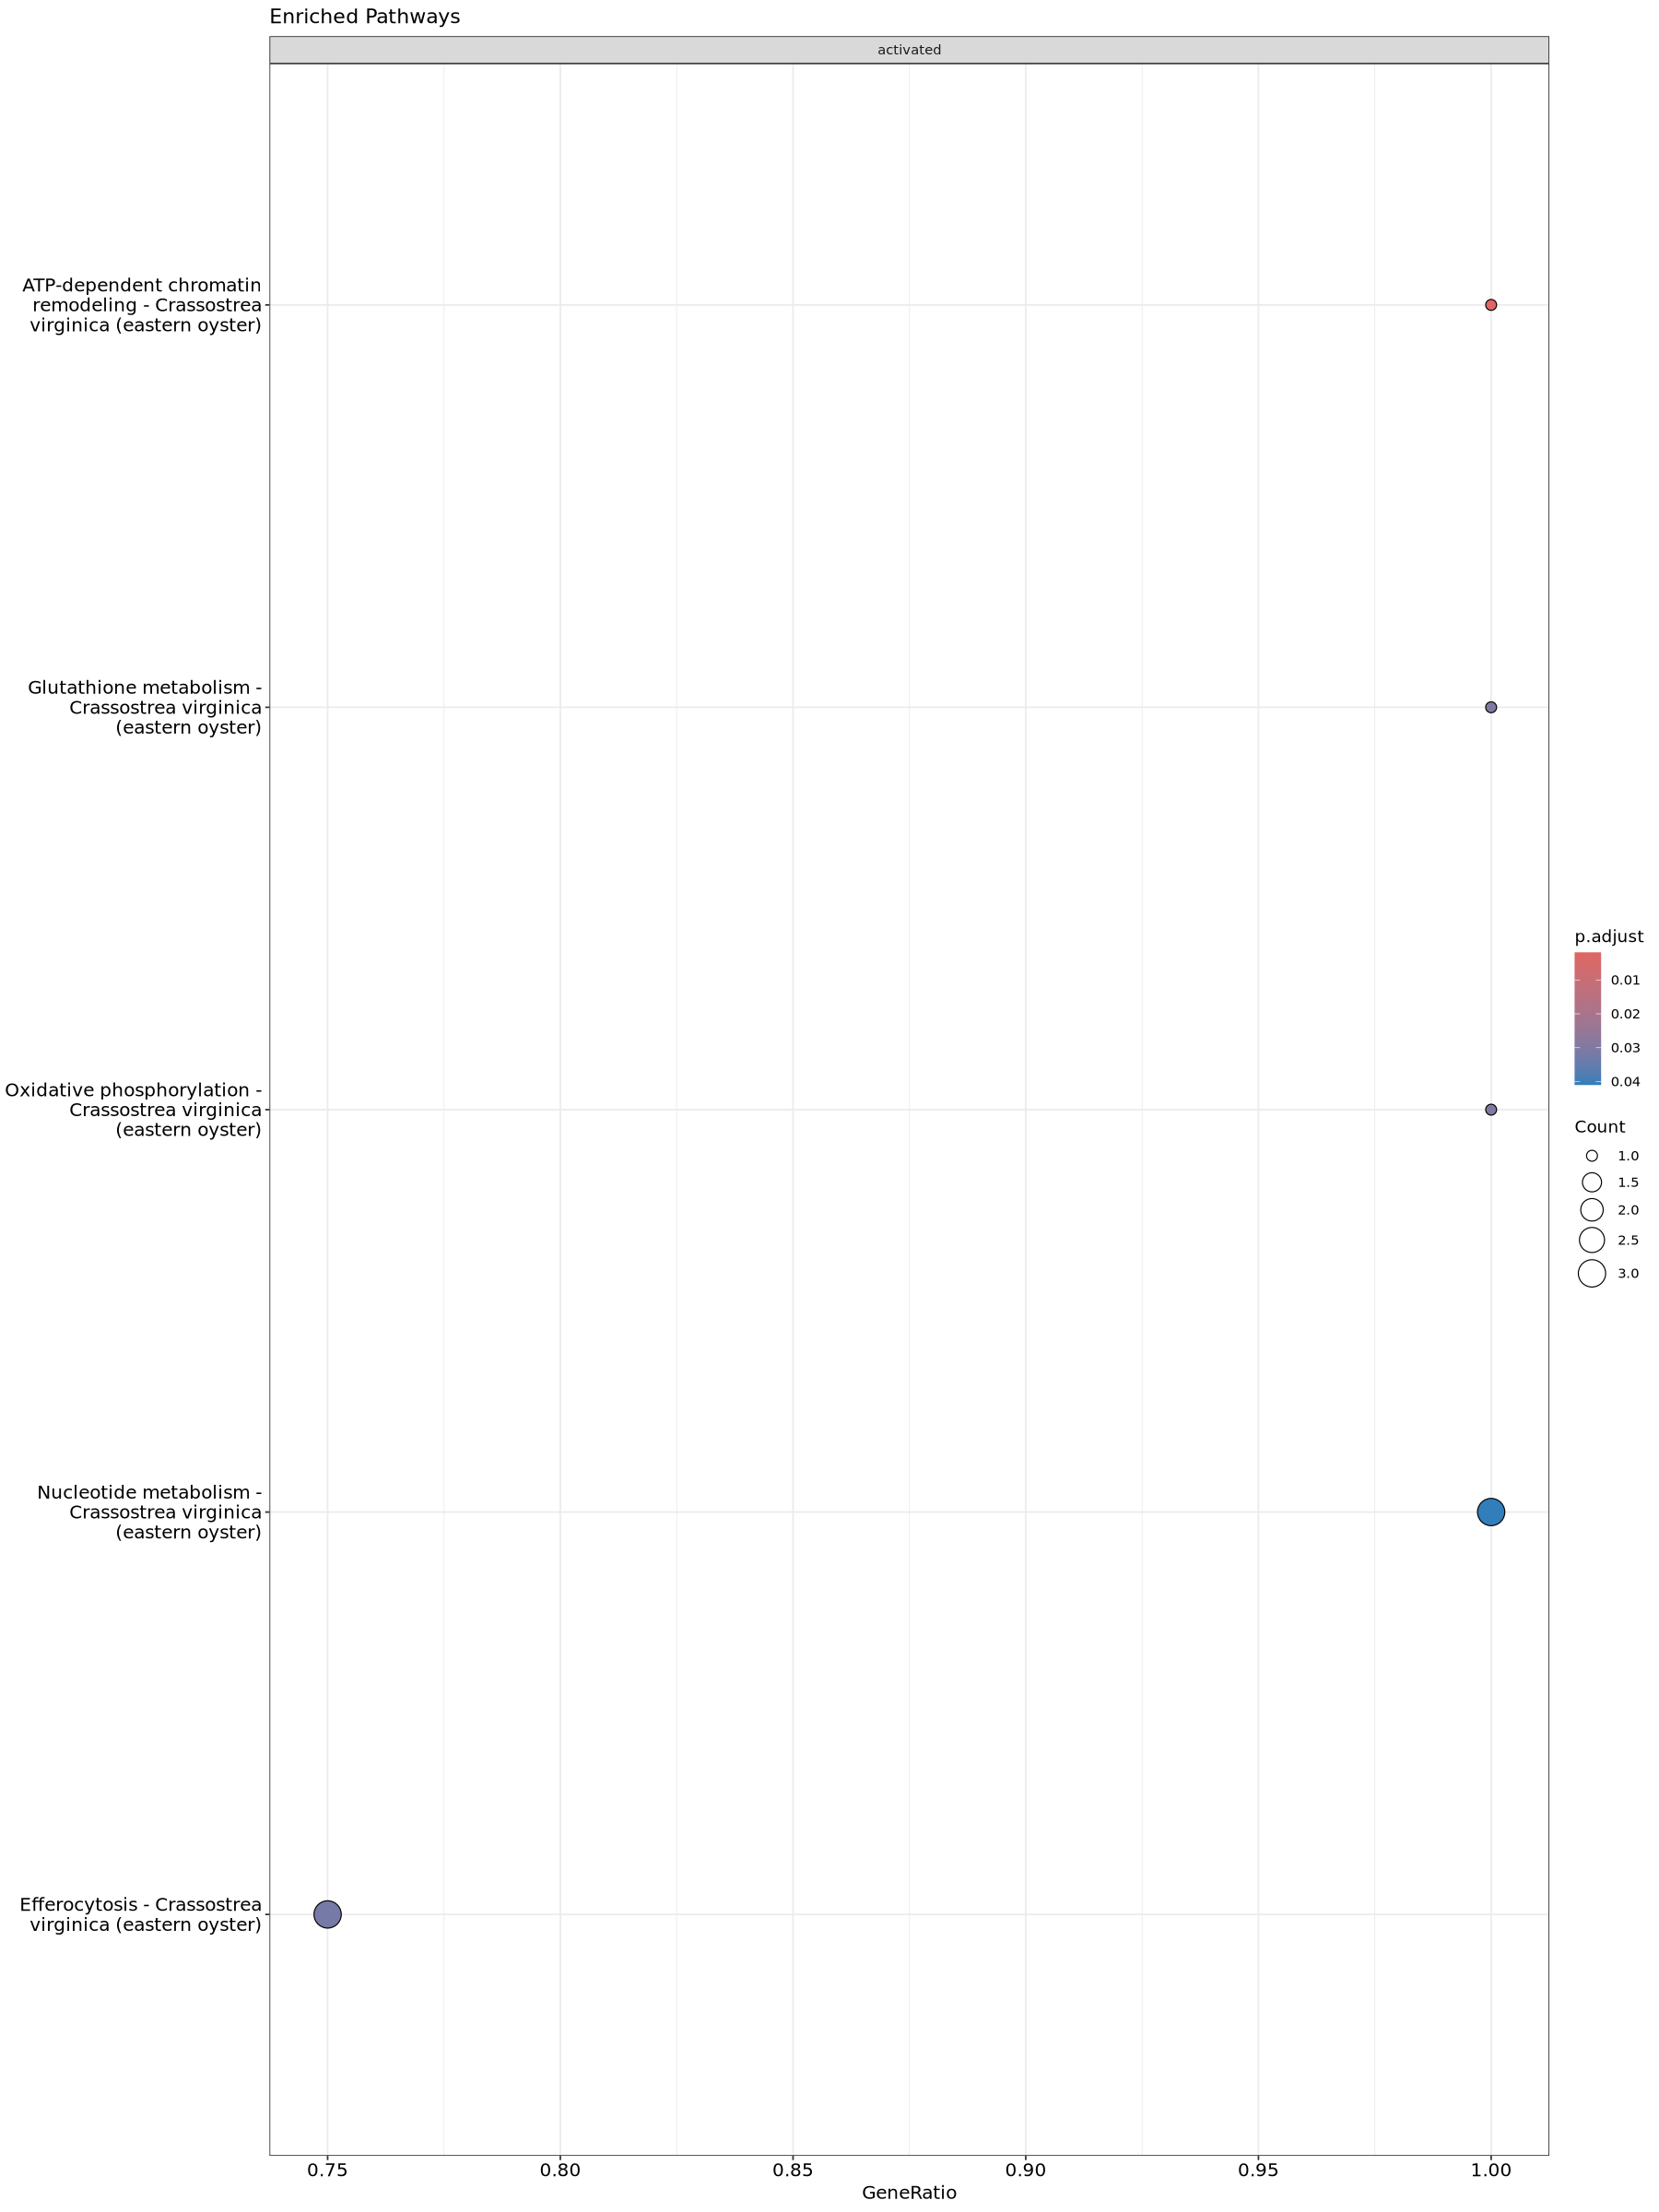

In [95]:
dotplot(kk2, showCategory = 10, title = "Enriched Pathways" , split=".sign") + facet_grid(.~.sign)

Warning message in cnetplot.enrichResult(x, ...):
“Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


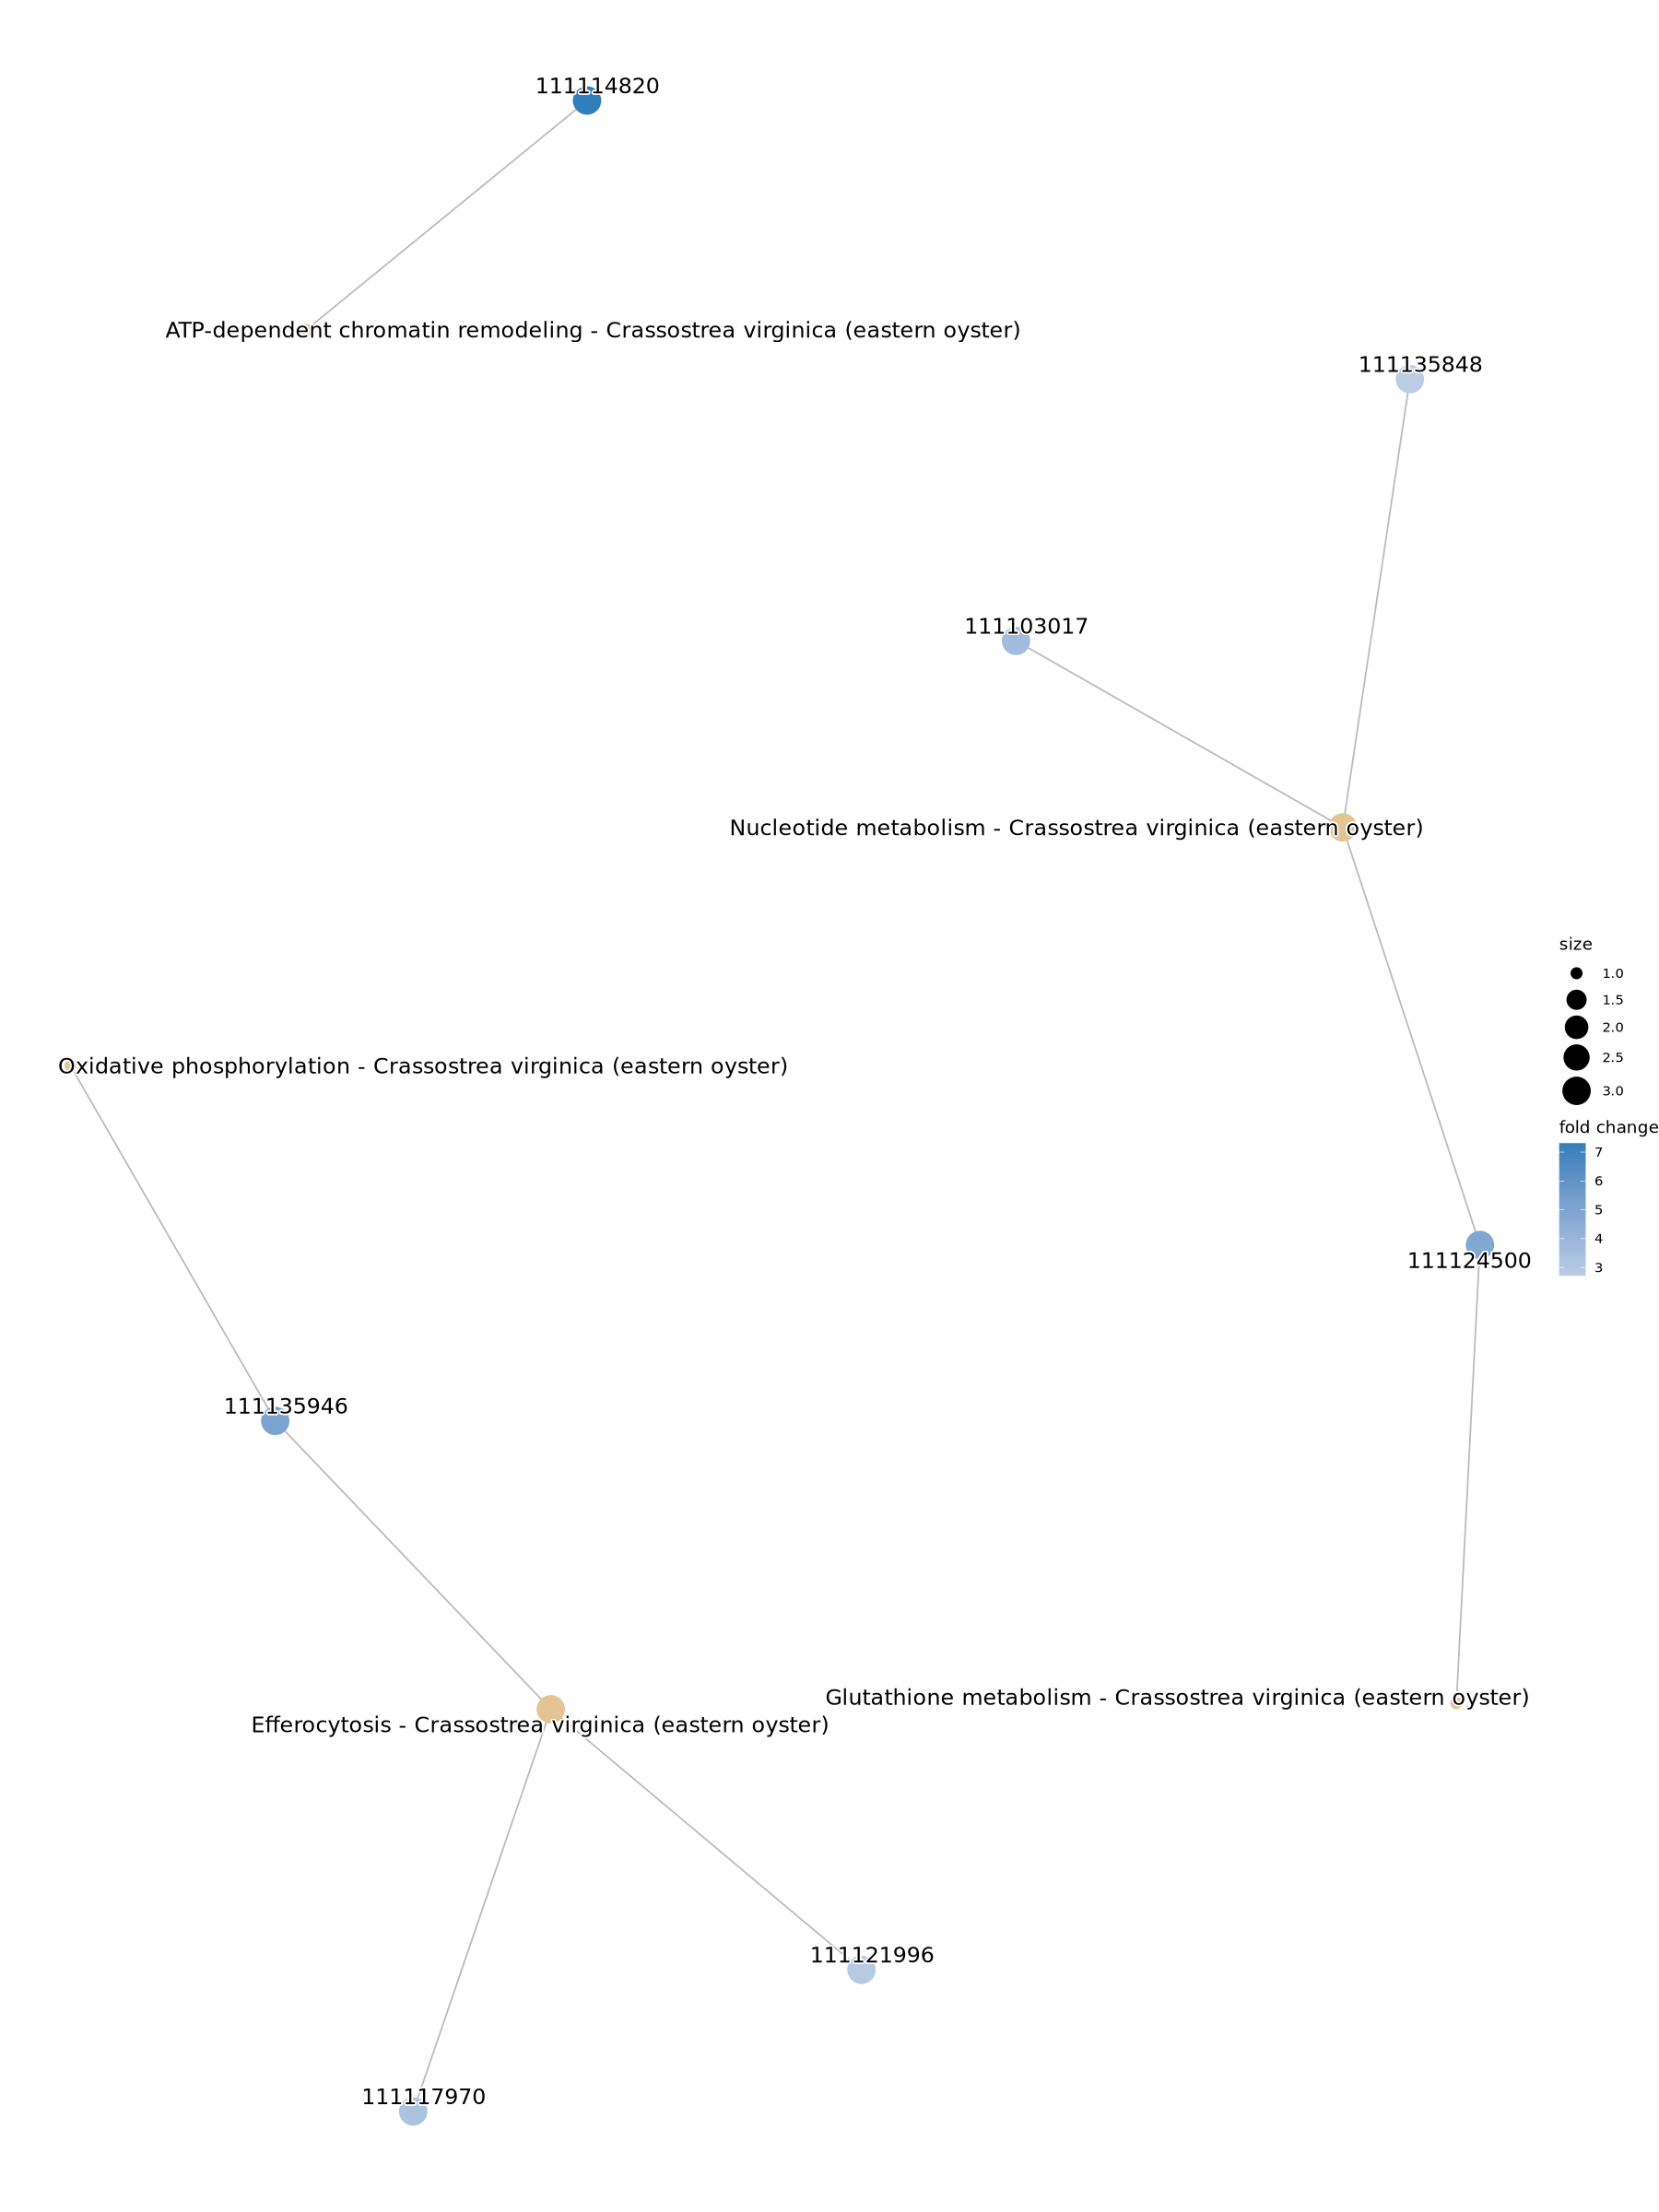

In [96]:
# categorySize can be either 'pvalue' or 'geneNum'
cnetplot(kk2, categorySize="geneNum", foldChange=kegg_gene_list)

In [71]:
#BiocManager::install('ggridges')
library(ggridges)

In [112]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df) # actually shows the entire df since there's only 5 pathways with pval<0.05

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
cvn03082,cvn03082,ATP-dependent chromatin remodeling,1,1.0000000,2.069162,0.001905424,0.1581502,0.1564453,1,"tags=100%, list=0%, signal=100%",111114820
cvn00190,cvn00190,Oxidative phosphorylation,1,0.9800000,2.027778,0.022078841,0.6965035,0.6889952,9,"tags=100%, list=2%, signal=98%",111135946
cvn00480,cvn00480,Glutathione metabolism,1,0.9625000,1.991568,0.041958042,0.6965035,0.6889952,16,"tags=100%, list=4%, signal=96%",111124500
cvn04148,cvn04148,Efferocytosis,4,0.7083055,1.816432,0.035964036,0.6965035,0.6889952,84,"tags=75%, list=21%, signal=60%",111135946/111117970/111121996
cvn01232,cvn01232,Nucleotide metabolism,3,0.7437186,1.805515,0.034965035,0.6965035,0.6889952,105,"tags=100%, list=26%, signal=74%",111124500/111103017/111135848
cvn00620,cvn00620,Pyruvate metabolism,1,0.9250000,1.913975,0.074925075,0.7123331,0.7046542,31,"tags=100%, list=8%, signal=92%",111128687


In [73]:
#options(repr.plot.width=15, repr.plot.height=20)

Picking joint bandwidth of 0.517



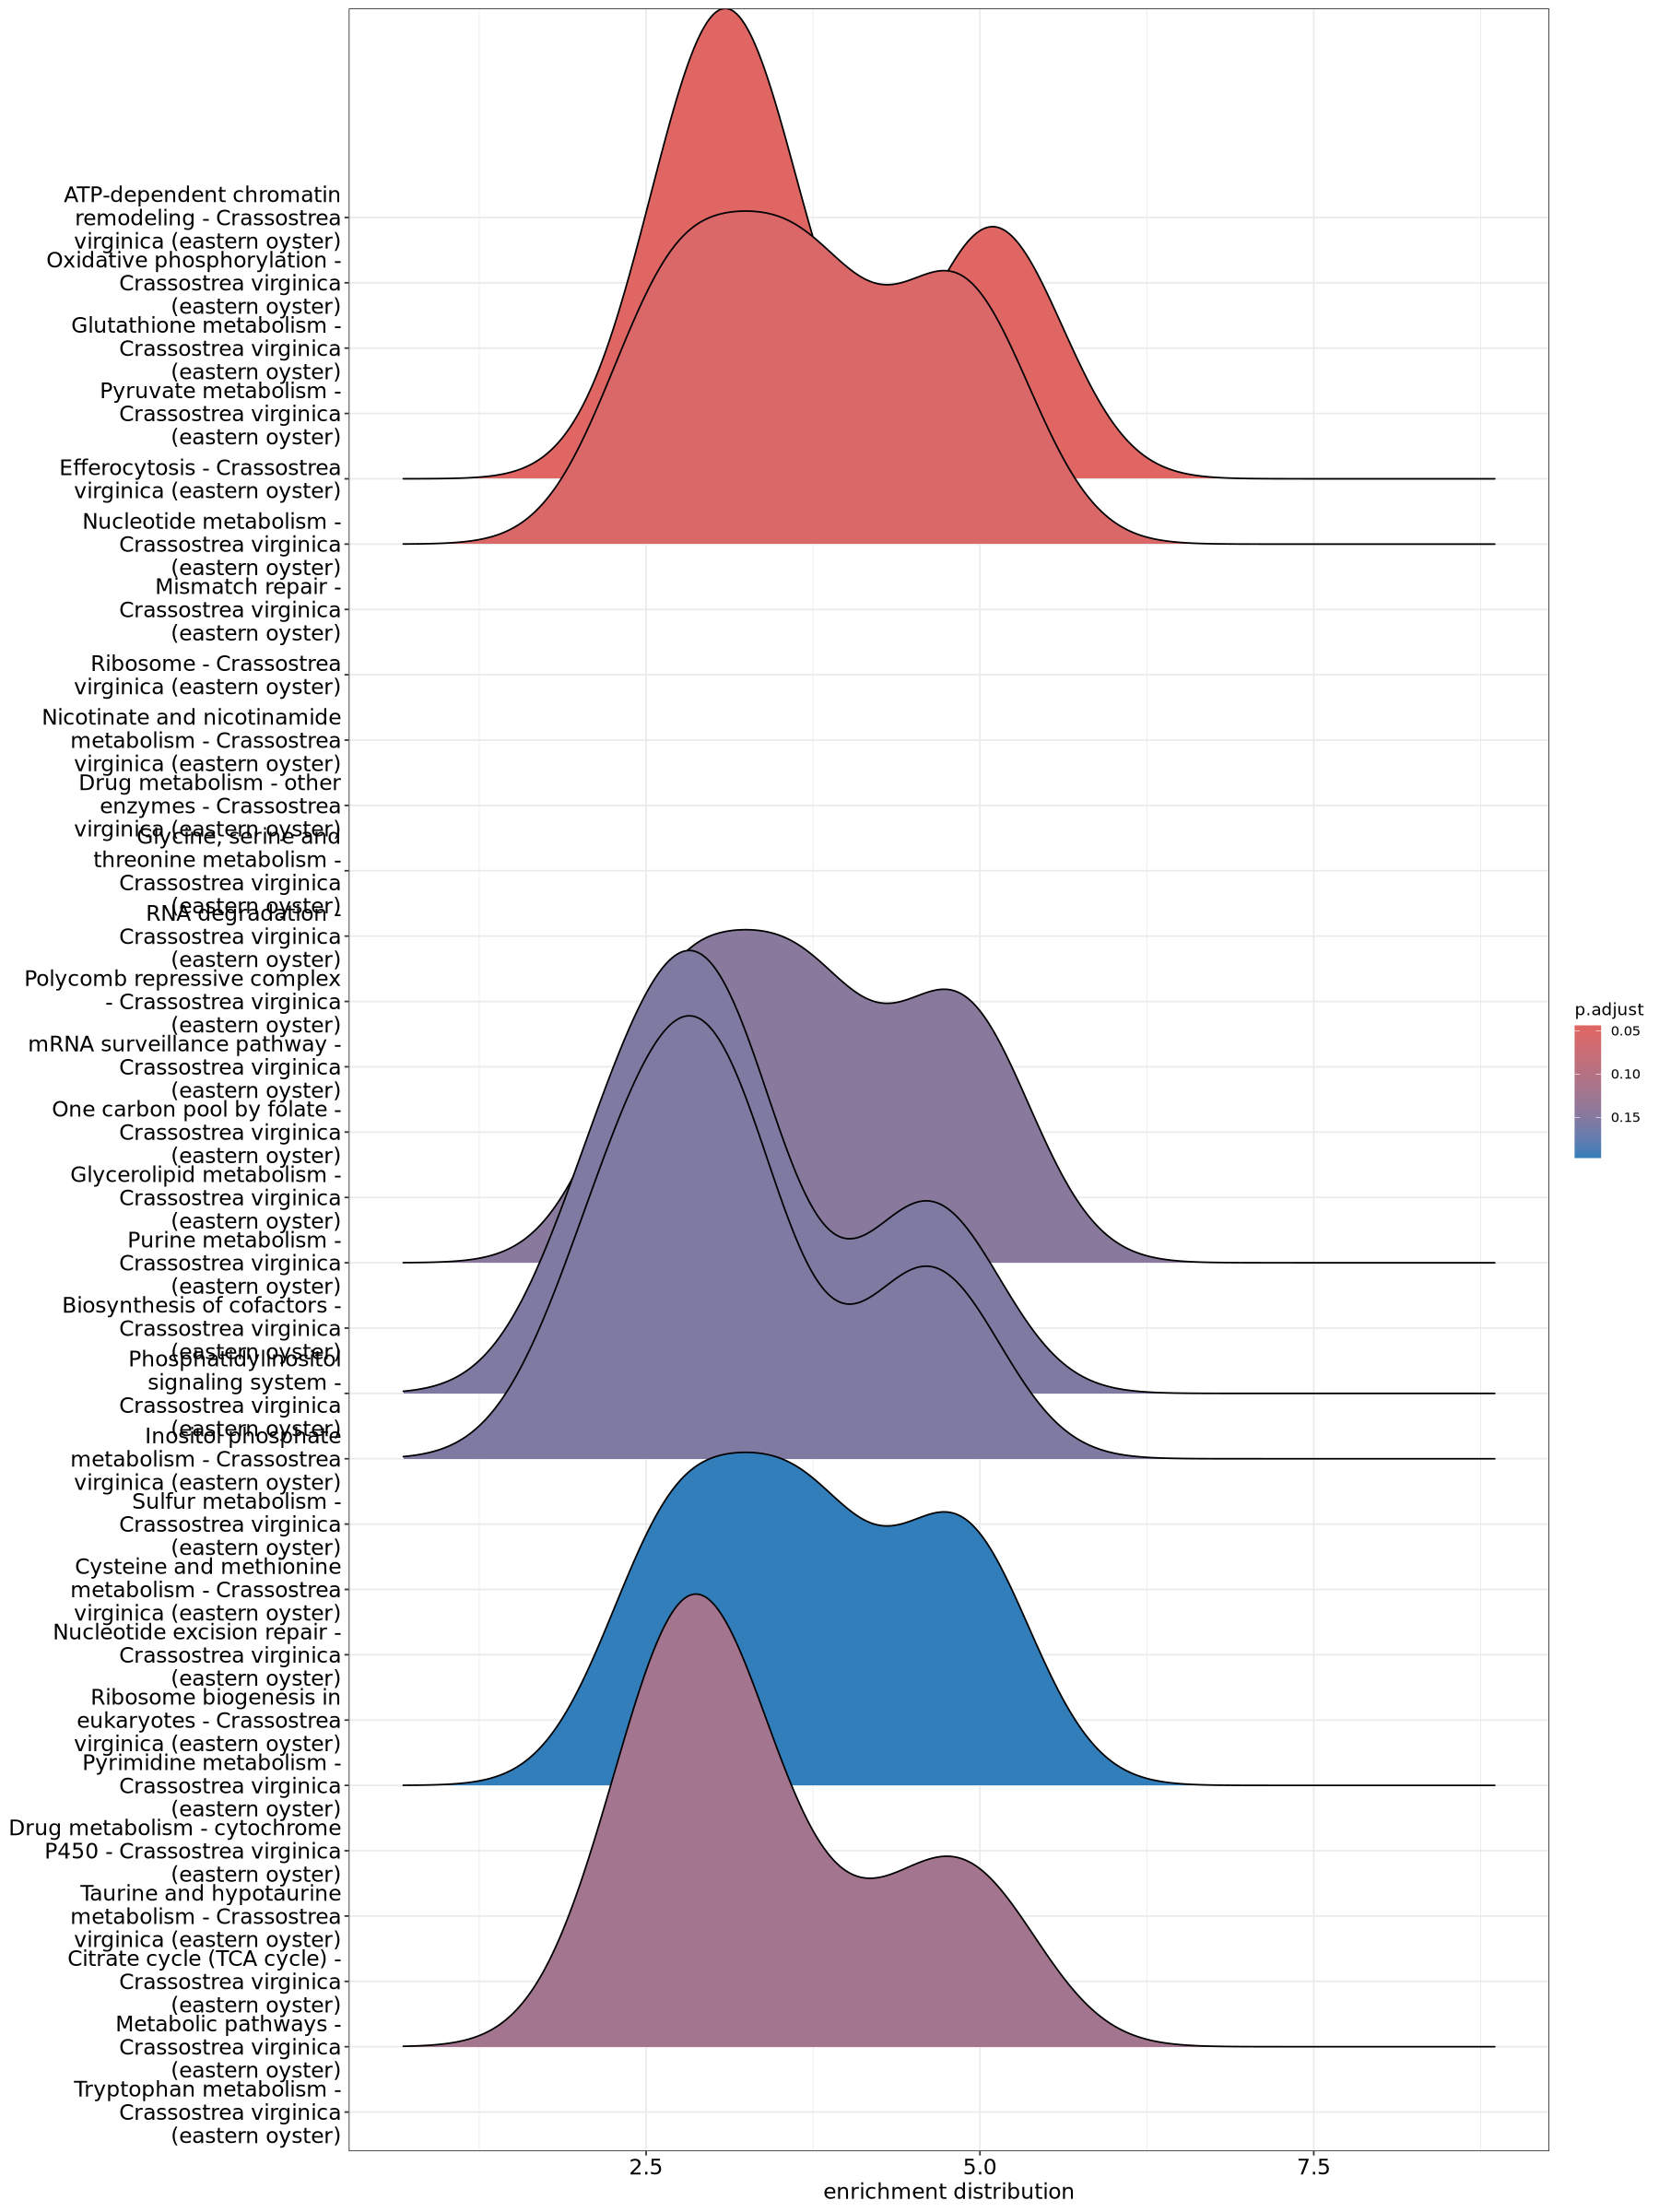

In [87]:
ridgeplot(kk2) + labs(x = "enrichment distribution")

helpful [link](https://support.bioconductor.org/p/9150431/)

In [75]:
entrez_genes <- as.character(dedup_df$gene)
head(entrez_genes)

[1] "111099115" "111099216" "111099417" "111099424" "111099722" "111099918"

here just using the list of genes of interest - doesn't take into account any statistical metrics (like log2FoldChange or pvalue)

### enrichKEGG - over-representation analysis

enrichKEGG is a KEGG pathway over-representation analysis

In [76]:
kegg <- enrichKEGG(gene = entrez_genes, organism = 'cvn', keyType="kegg", pvalueCutoff = 1)
kegg

#
# over-representation test
#
#...@organism 	 cvn 
#...@ontology 	 KEGG 
#...@keytype 	 kegg 
#...@gene 	 chr [1:401] "111099115" "111099216" "111099417" "111099424" "111099722" ...
#...pvalues adjusted by 'BH' with cutoff <1 
#...3 enriched terms found
'data.frame':	3 obs. of  11 variables:
 $ category   : chr  "Cellular Processes" "Metabolism" "Cellular Processes"
 $ subcategory: chr  "Cell motility" "Carbohydrate metabolism" "Transport and catabolism"
 $ ID         : chr  "cvn04814" "cvn00562" "cvn04144"
 $ Description: chr  "Motor proteins - Crassostrea virginica (eastern oyster)" "Inositol phosphate metabolism - Crassostrea virginica (eastern oyster)" "Endocytosis - Crassostrea virginica (eastern oyster)"
 $ GeneRatio  : chr  "10/105" "5/105" "11/105"
 $ BgRatio    : chr  "149/5086" "53/5086" "220/5086"
 $ pvalue     : num  0.000914 0.004455 0.005341
 $ p.adjust   : num  0.0722 0.1407 0.1407
 $ qvalue     : num  0.0712 0.1387 0.1387
 $ geneID     : chr  "111100344/111107250/11111

In [77]:
as.data.frame(kegg)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
cvn04814,Cellular Processes,Cell motility,cvn04814,Motor proteins - Crassostrea virginica (eastern oyster),10/105,149/5086,0.0009143516,0.07223378,0.07122318,111100344/111107250/111112439/111115784/111125905/111129526/111131555/111131749/111134768/111134843,10
cvn00562,Metabolism,Carbohydrate metabolism,cvn00562,Inositol phosphate metabolism - Crassostrea virginica (eastern oyster),5/105,53/5086,0.0044548022,0.14065847,0.13869056,111100148/111101050/111112578/111125442/111127799,5
cvn04144,Cellular Processes,Transport and catabolism,cvn04144,Endocytosis - Crassostrea virginica (eastern oyster),11/105,220/5086,0.0053414608,0.14065847,0.13869056,111110660/111112439/111112700/111115795/111116971/111120187/111125223/111125352/111125956/111127289/111136896,11


only 3 kegg pathways identified - only statisticall signficiant when looking at the pvalue - not p-adjusted

#### enrichMKEGG
'KEGG Module is a collection of manually defined function units. In some situation, KEGG Modules have a more straightforward interpretation.' [source](https://yulab-smu.top/biomedical-knowledge-mining-book/clusterprofiler-kegg.html)

probably just ignore this... don't know that it's helpful in any way for us

In [103]:
mkk <- enrichMKEGG(gene = entrez_genes,
                   organism = 'cvn',
                   pvalueCutoff = 1,
                   qvalueCutoff = 1)
head(mkk) 

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
M00173,M00173,Reductive citrate cycle (Arnon-Buchanan cycle),2/23,11/948,0.02712315,0.2932198,0.2700709,111117164/111128687,2
M00130,M00130,"Inositol phosphate metabolism, PI=> PIP2 => Ins(1,4,5)P3 => Ins(1,3,4,5)P4",2/23,14/948,0.04293551,0.2932198,0.2700709,111100148/111101050,2
M00038,M00038,"Tryptophan metabolism, tryptophan => kynurenine => 2-aminomuconate",2/23,16/948,0.05497871,0.2932198,0.2700709,111108303/111127901,2
M00959,M00959,"Guanine ribonucleotide degradation, GMP => Urate",2/23,21/948,0.08942739,0.3348695,0.3084325,111103017/111135848,2
M00958,M00958,"Adenine ribonucleotide degradation, AMP => Urate",2/23,23/948,0.10464673,0.3348695,0.3084325,111103017/111135848,2
M00165,M00165,Reductive pentose phosphate cycle (Calvin cycle),1/23,10/948,0.21869993,0.4294252,0.3955232,111122808,1


### Ordering gene list
for rank tests, the gene list needs to be ranked by some sort of score of gene expression (like log2FoldChange or pval)

so now going to order my list of genes of interest in decreasing order by log2FoldChange

In [78]:
# reading in df
gene_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/sig_p1_wc_genes.csv')
#head(gene_df)

# pulling out only the columns I want
# library(dplyr) # to use select() function
genes_l2fc <- select(gene_df, Row.names, log2FoldChange)

# renaming columns to make it easier
colnames(genes_l2fc) <- c('genes', 'l2fc')
head(genes_l2fc)

,genes,l2fc
,<chr>,<dbl>
1,LOC111099115,1.7885864
2,LOC111099216,1.4828614
3,LOC111099417,2.7487429
4,LOC111099424,3.4384445
5,LOC111099722,0.8993515
6,LOC111099918,0.6567512


In [79]:
# ordering the gene list in decreasing order
l2fc_sorted <- genes_l2fc[order(-genes_l2fc$l2fc),]
head(l2fc_sorted)

write.csv(l2fc_sorted, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/l2fc_sorted.csv')

,genes,l2fc
,<chr>,<dbl>
116,LOC111114820,7.304551
115,LOC111114521,6.538482
169,LOC111119752,6.248138
69,LOC111107999,6.053723
51,LOC111105528,6.017344
238,LOC111125118,5.965434
